In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import pims
import pickle
from skimage.measure import regionprops
from pathlib import Path
from gzip import GzipFile

In [8]:
def get_channel_index(chan,num_zs=7,z_indices = range(7)):
    cycle = chan//4
    channel = chan%4
    index = [cycle*4*num_zs+(z*4)+channel for z in z_indices]
    return index  

    
    
def read_cells(tile_name,cell_data):
    '''
    extract cells of given tile.  
    
    tile_name:  string of tile name (not including '.tif' e.g: reg005_X01_Y01)
    cell_data:  dataframe of cell regions, expression info and other meta data
    
    returns subset of cell_data corresponding to a tile and dict with keys as CellID and values as np array of region pixels 
    *note values are in x,y format (not rows, cols)
    '''
    tile_cells = cell_data[cell_data['tilename']==tile_name]
    roisX = np.core.defchararray.split(tile_cells['Xroi'].values.astype(str),sep = '_')
    roisY = np.core.defchararray.split(tile_cells['Yroi'].values.astype(str),sep = '_')
    roi = {i:np.array([x,y]).astype(int) for (i,x,y) in zip(tile_cells['CellID'].values,roisX,roisY) if (len(x)>1 and len(y)>1)} 
    return tile_cells,roi

def read_tile_image(tile_name,channelNames,markers,zs,tile_direc ):
    '''
    extract desired channels and zs from raw image
    
    tile_name:  string of tile name (not including '.tif' e.g: reg005_X01_Y01)
    channelNames:  list of proteins in order found in image (not including Zs)
    markers:    list of proteins to view  e.g: PD1,CD3 etc 
    zs:         list of z coordinates to extract
    tile_direc:  directory where tile data is saved
    
    *note raw image is flattened from following shape (num_cycles,num_zs,num_channels)
    
    returns: numpy array in following shape (num_markers,num_zs,nrows,ncols)
    '''
    indices = [get_channel_index(channelNames.index(marker),z_indices = zs) for marker in markers]
    indices = [k for i in indices for k in i]
    path = tile_direc / '{}.tif'.format(tile_name)
    s = pims.TiffStack(path)
    img = np.array(s[indices]).reshape(len(markers),len(zs),*s.frame_shape)
    return img


def match_tile_and_cells(tile_name,cell_data,channelNames,markers,tile_direc = home_path / 'mouse_number_89_reg005_tiles'):
    '''
    wrapper function to get imge and cells of a given tile with desired markers and zs 
    
    tile_name:  string of tile name (not including '.tif' e.g: reg005_X01_Y01)
    cell_data:  dataframe of cell regions, expression info and other meta data
    channelNames:  list of proteins in order found in image (not including Zs)
    markers:    list of proteins to view  e.g: PD1,CD3 etc
    tile_direc:  directory where tile data is saved
    
    returns: np.array(num_markers,num_zs,nrows,ncols),dataframe (subset of cell_data), dict cellid: cell pixels (x,y))
    
    '''
    img = read_tile_image(tile_name,channelNames,markers,zs,tile_direc)
    tile_cells,roi = read_cells(tile_name,cell_data)
    return img,tile_cells,roi
    
    
    
    

## Cell Tensors


In [9]:
tile_names = [i.split('.tif')[0] for i in os.listdir(home_path / 'mouse_number_89_reg005_tiles') if 'tif' in i]

In [72]:
home_path = Path('/home/idies/workspace/codex/PD1_polarization/')
cell_data = pd.read_csv('rcnnPD1pos_by_TYRP1UNcomp_PD1UNcomp.txt')
cell_data = cell_data.rename(
    columns = {"X1": "segmentation_ix", "Tile Row": "tile_y", "Tile Col": "tile_x", "Tile Z": "tile_z", "In-Tile Y": "cell_tile_y", "In-Tile X": "cell_tile_x"}
)

In [73]:
cell_data.head()

,segmentation_ix,Reg,tile_y,tile_x,tile_z,cell_tile_y,cell_tile_x,Absolute Y,Absolute X,Cell Size,...,segf233_UNcomp,segf234_UNcomp,segf241_UNcomp,segf242_UNcomp,segf243_UNcomp,segf244_UNcomp,segf251_UNcomp,segf252_UNcomp,segf253_UNcomp,segf254_UNcomp
0,80,5,1,1,11,701.324324,261.054054,701,261,186,...,3468.032258,3468.032258,11783.215054,11783.215054,12866.064516,12866.064516,6182.258065,6182.258065,7117.930108,7117.930108
1,212,5,1,1,11,716.507692,264.353846,717,264,140,...,1584.450000,1584.450000,12921.900000,12921.900000,11500.878571,11500.878571,6286.750000,6286.750000,3635.735714,3635.735714
2,219,5,1,1,11,705.239583,276.666667,705,277,223,...,2402.470852,2402.470852,13242.367713,13242.367713,12989.067265,12989.067265,6563.331839,6563.331839,4254.322870,4254.322870
3,122,5,2,1,10,13.150538,283.225806,733,283,189,...,7170.661376,7170.661376,12770.460317,12770.460317,15337.449735,15337.449735,5986.857143,5986.857143,13440.227513,13440.227513
4,128,5,2,1,10,32.719298,135.298246,753,135,154,...,1584.824675,1584.824675,11859.629870,11859.629870,11903.779221,11903.779221,5830.935065,5830.935065,3637.285714,3637.285714


In [26]:
test = next(iter(cell_data.itertuples()))

In [68]:
save_dir = Path('/home/idies/workspace/Storage/bmyury/shared_scripts_and_files/rcnn_cell_tensors')
save_dir.mkdir(exist_ok=True)

channelNames = list(pd.read_csv(home_path / 'channelNames.txt', header = None)[0].values)

In [19]:
def get_segmentation_mask(
    tile_x, tile_y, tile_z, pattern='reg005_X{x:02d}_Y{y:02d}_Z{z:02d}visual_growth3labeled_mask.tif', directory='reg5_Graham_masks'
):
    img = pims.TiffStack(Path(directory) / pattern.format(x=tile_x, y=tile_y, z=tile_z))
    return np.array(img)[0, ...]

In [47]:
%pdb

Automatic pdb calling has been turned ON


In [76]:
def make_cell_stack(
    cell_data, channelNames, markers,
    mask_cells=True, box_size=32, tile_path=home_path / 'mouse_number_89_reg005_tiles',
    tile_pattern='reg005_X{x:02d}_Y{y:02d}'
):
    cell_data["cell_idx"] = np.arange(cell_data.shape[0])
    cell_stack = np.empty((cell_data.shape[0], len(markers), box_size, box_size), dtype=np.uint16)
    skipped_cells = []
    cd_grouped = cell_data.groupby(["tile_z", "tile_x", "tile_y"])
    for (z, tx, ty), cd in cd_grouped:
        print((tx, ty, z))
        tn = tile_pattern.format(x=tx, y=ty)
        img = read_tile_image(tn, channelNames, markers, [z], tile_path)
        img = np.pad(img, ((0, 0), (0, 0), (box_size, box_size), (box_size, box_size)))
        if mask_cells:
            segmentation_mask = get_segmentation_mask(tx, ty, z)
            segmentation_mask = np.pad(segmentation_mask, box_size)
        for c in cd.itertuples():
            center = (int(c.cell_tile_y + box_size), int(c.cell_tile_x + box_size))
            coords = (
                ((int(center[0]) - box_size//2), (int(center[0]) + box_size//2)),
                ((int(center[1]) - box_size//2), (int(center[1]) + box_size//2))
            )
            ci = img[
                :,
                0,
                coords[0][0]:coords[0][1],
                coords[1][0]:coords[1][1]
            ]
            if mask_cells:
                mask = segmentation_mask[
                    coords[0][0]:coords[0][1],
                    coords[1][0]:coords[1][1]
                ]
                ci = ci.copy()
                ci[:, mask != c.segmentation_ix] = 0
#             if ci.shape == (len(markers), box_size, box_size):
            cell_stack[c.cell_idx, :, :, :] = ci
#             else:
#                 skipped_cells.append(c.cell_ix)
    return cell_data[~cell_data.cell_idx.isin(skipped_cells)], np.delete(cell_stack, np.array(skipped_cells) - 1, axis=0)

In [83]:
cell_data_stack, cell_stack = make_cell_stack(cell_data, channelNames, channelNames, mask_cells=False)

(7, 4, 6)
(7, 8, 6)
(4, 8, 7)
(5, 3, 7)
(5, 8, 7)
(5, 9, 7)
(6, 3, 7)
(6, 4, 7)
(6, 8, 7)
(6, 9, 7)
(7, 2, 7)
(7, 3, 7)
(7, 5, 7)
(7, 7, 7)
(7, 9, 7)
(3, 4, 8)
(3, 8, 8)
(3, 9, 8)
(4, 2, 8)
(4, 4, 8)
(4, 9, 8)
(5, 2, 8)
(5, 4, 8)
(5, 5, 8)
(5, 7, 8)
(6, 1, 8)
(6, 2, 8)
(6, 5, 8)
(6, 6, 8)
(6, 7, 8)
(7, 1, 8)
(7, 6, 8)
(1, 8, 9)
(1, 9, 9)
(2, 8, 9)
(2, 9, 9)
(3, 2, 9)
(3, 3, 9)
(4, 5, 9)
(5, 1, 9)
(1, 2, 10)
(1, 3, 10)
(1, 7, 10)
(2, 3, 10)
(2, 7, 10)
(3, 1, 10)
(3, 5, 10)
(3, 6, 10)
(3, 7, 10)
(4, 1, 10)
(4, 6, 10)
(4, 7, 10)
(5, 6, 10)
(1, 1, 11)


/home/idies/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


In [78]:
print('cell_data_stack shape', cell_data_stack.shape)
print('cell_stack shape', cell_stack.shape)

cell_data_stack shape (3223, 111)
cell_stack shape (3223, 88, 32, 32)


In [79]:
len(channelNames)

88

In [80]:
cell_data_stack

,segmentation_ix,Reg,tile_y,tile_x,tile_z,cell_tile_y,cell_tile_x,Absolute Y,Absolute X,Cell Size,...,segf234_UNcomp,segf241_UNcomp,segf242_UNcomp,segf243_UNcomp,segf244_UNcomp,segf251_UNcomp,segf252_UNcomp,segf253_UNcomp,segf254_UNcomp,cell_idx
0,80,5,1,1,11,701.324324,261.054054,701,261,186,...,3468.032258,11783.215054,11783.215054,12866.064516,12866.064516,6182.258065,6182.258065,7117.930108,7117.930108,0
1,212,5,1,1,11,716.507692,264.353846,717,264,140,...,1584.450000,12921.900000,12921.900000,11500.878571,11500.878571,6286.750000,6286.750000,3635.735714,3635.735714,1
2,219,5,1,1,11,705.239583,276.666667,705,277,223,...,2402.470852,13242.367713,13242.367713,12989.067265,12989.067265,6563.331839,6563.331839,4254.322870,4254.322870,2
3,122,5,2,1,10,13.150538,283.225806,733,283,189,...,7170.661376,12770.460317,12770.460317,15337.449735,15337.449735,5986.857143,5986.857143,13440.227513,13440.227513,3
4,128,5,2,1,10,32.719298,135.298246,753,135,154,...,1584.824675,11859.629870,11859.629870,11903.779221,11903.779221,5830.935065,5830.935065,3637.285714,3637.285714,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3218,1034,5,9,7,7,149.500000,327.500000,4398,4648,104,...,1271.605769,12443.750000,12443.750000,5417.317308,5417.317308,8798.076923,8798.076923,3050.740385,3050.740385,3218
3219,1038,5,9,7,7,162.500000,284.000000,4410,4604,114,...,1357.500000,15303.359649,15303.359649,8483.333333,8483.333333,10606.140351,10606.140351,4025.622807,4025.622807,3219
3220,1096,5,9,7,7,87.043478,662.594203,4335,4983,120,...,3910.983333,10493.133333,10493.133333,11068.891667,11068.891667,10602.808333,10602.808333,9967.466667,9967.466667,3220
3221,1099,5,9,7,7,492.673913,319.717391,4741,4640,106,...,3540.216981,14141.981132,14141.981132,13393.179245,13393.179245,11416.301887,11416.301887,14836.141509,14836.141509,3221


In [84]:
np.save(
    save_dir / "all_cells_markers_tensor_unmasked.npy",
    cell_stack
)

In [82]:
cell_data_stack.to_csv(
    save_dir / "all_cells_markers_data.csv",
    index=False
)

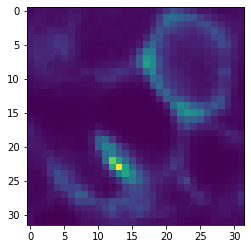

In [101]:
plt.imshow(cell_stack[50, 39, ...])